# GBM
- Data Split 
    - Apply 80/20 split by Ticker
    - For calculating performance, use 5 fold cross validation (RMSE, Accuracy (1 if positive, 0 if not))
- Build GBM by Ticker

In [456]:
import xgboost
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [457]:
TICKER = "AAPL"
TEST_FRAC = 0.20
RESPONSE_VAR = "close_t+5"

In [458]:
df = pd.read_parquet("../data/processed/daily_with_finbert_and_indicators.parquet")

In [459]:
df["ticker"].unique()

array(['AAPL', 'AMZN', 'HD', 'JPM', 'KO', 'MSFT', 'NVDA', 'TSLA', 'UNH',
       'XOM'], dtype=object)

In [460]:
df = df.query(f"ticker == '{TICKER}'").reset_index(drop=True)

In [461]:
df.shape

(249, 805)

In [462]:
df.head()

,ticker,date,open,high,low,close,volume,return_t+1,headlines,finbert_0,...,open_smoothed_alpha:0.9,close_smoothed_alpha:0.25,close_smoothed_alpha:0.75,close_smoothed_alpha:0.9,return_t+1_smoothed_alpha:0.25,return_smoothed_alpha:0.25,return_t+1_smoothed_alpha:0.75,return_smoothed_alpha:0.75,return_t+1_smoothed_alpha:0.9,return_smoothed_alpha:0.9
0,AAPL,2024-05-01,169.580002,172.710007,169.110001,169.300003,50383100.0,0.022032,[],0.000000,...,169.580002,169.300003,169.300003,169.300003,0.022032,NaN,0.022032,NaN,0.022032,NaN
1,AAPL,2024-05-02,172.509995,173.419998,170.889999,173.029999,94214900.0,0.059816,[],0.000000,...,172.216995,170.232502,172.097500,172.656999,0.031478,0.022032,0.050370,0.022032,0.056038,0.022032
2,AAPL,2024-05-03,186.649994,187.000000,182.660004,183.380005,163224100.0,-0.009107,[],0.000000,...,185.206694,173.519378,180.559379,182.307704,0.021332,0.031478,0.005762,0.050370,-0.002592,0.056038
3,AAPL,2024-05-06,182.350006,184.199997,180.419998,181.710007,78569700.0,0.003797,[],0.000000,...,182.635675,175.567035,181.422350,181.769776,0.016948,0.021332,0.004289,0.005762,0.003158,-0.002592
4,AAPL,2024-05-07,183.449997,184.899994,181.320007,182.399994,77305800.0,0.001864,[From Apple to Wayfair: A Lot of Earnings Resu...,0.030524,...,183.368565,177.275275,182.155583,182.336972,0.013177,0.016948,0.002470,0.004289,0.001994,0.003158


In [463]:
df.tail()

,ticker,date,open,high,low,close,volume,return_t+1,headlines,finbert_0,...,open_smoothed_alpha:0.9,close_smoothed_alpha:0.25,close_smoothed_alpha:0.75,close_smoothed_alpha:0.9,return_t+1_smoothed_alpha:0.25,return_smoothed_alpha:0.25,return_t+1_smoothed_alpha:0.75,return_smoothed_alpha:0.75,return_t+1_smoothed_alpha:0.9,return_smoothed_alpha:0.9
244,AAPL,2025-04-23,206.000000,208.000000,202.800003,204.600006,52929200.0,0.018426,[Wall Street Bets on Big Tech Buybacks as Free...,-0.034162,...,204.987588,199.016937,203.030261,204.051834,0.012118,0.010015,0.019765,0.023781,0.019063,0.024799
245,AAPL,2025-04-24,204.889999,208.830002,202.940002,208.369995,47311000.0,0.004367,[Apple to Strip Secret Robotics Unit From AI C...,0.015404,...,204.899758,201.355202,207.035062,207.938179,0.010180,0.012118,0.008217,0.019765,0.005837,0.019063
246,AAPL,2025-04-25,206.369995,209.750000,206.199997,209.279999,38222300.0,0.004109,"[Tariff uncertainty creeps into tech earnings,...",0.112134,...,206.222971,203.336401,208.718764,209.145817,0.008662,0.010180,0.005136,0.008217,0.004282,0.005837
247,AAPL,2025-04-28,210.000000,211.500000,207.460007,210.139999,38743100.0,0.005092,[My 10 Must-Own Dividend Stocks For Your Retir...,-0.046616,...,209.622297,205.037301,209.784691,210.040581,0.007770,0.008662,0.005103,0.005136,0.005011,0.004282
248,AAPL,2025-04-29,208.690002,212.240005,208.369995,211.210007,36827600.0,0.006108,[Stocks Rise as Fed-Cut Wagers Sink Treasury Y...,0.026925,...,208.783232,206.580477,210.853678,211.093064,0.007354,0.007770,0.005856,0.005103,0.005998,0.005011


## Add Close @ T+1 as a variable to test modeling

In [464]:
for lag in range(1, 6):
    df[f"close_t+{lag}"] = df["close"].shift(-lag)

In [465]:
df[["close", "close_t+1", "close_t+3", "close_t+5"]].head(10)

,close,close_t+1,close_t+3,close_t+5
0,169.300003,173.029999,181.710007,182.740005
1,173.029999,183.380005,182.399994,184.570007
2,183.380005,181.710007,182.740005,183.050003
3,181.710007,182.399994,184.570007,186.279999
4,182.399994,182.740005,183.050003,187.429993
5,182.740005,184.570007,186.279999,189.720001
6,184.570007,183.050003,187.429993,189.839996
7,183.050003,186.279999,189.720001,189.869995
8,186.279999,187.429993,189.839996,191.039993
9,187.429993,189.720001,189.869995,192.350006


In [466]:
df[["close", "close_t+1"]].tail()

,close,close_t+1
244,204.600006,208.369995
245,208.369995,209.279999
246,209.279999,210.139999
247,210.139999,211.210007
248,211.210007,NaN


In [467]:
df.dropna(subset=RESPONSE_VAR, inplace=True)

### Apply data split
- For initial test, build model on 80% and validate on 20% OOT
    - Tune hyperparameters using CV on Train set

- For future, always validate on most recent 2-months and add additional 

In [468]:
df = df.query(f"ticker == '{TICKER}'").reset_index(drop=True)

In [469]:
df = df.sort_values("date")

In [470]:
train = df.loc[df.index <= int(df.shape[0] * (1 - TEST_FRAC)), :]
test = df.loc[df.index > int(df.shape[0] * (1 - TEST_FRAC)), :]

In [471]:
train.shape, test.shape

((196, 810), (48, 810))

### Build initial model on `returns_t+1` 
- Use ARIMA as a baseline (and potentially use as a feature)
- Test using `close_t+1` and `return_t+1_>0`

In [472]:
keys = ["ticker", "date"]
non_modeling_vars = ["headlines", *[col for col in df.columns if "t+1" in col]]
print(non_modeling_vars)

['headlines', 'return_t+1', 'return_t+1_smoothed_alpha:0.25', 'return_t+1_smoothed_alpha:0.75', 'return_t+1_smoothed_alpha:0.9', 'close_t+1']


In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import numpy as np

# Prepare the features and target
X = train.drop(columns=keys + non_modeling_vars)
y = train[RESPONSE_VAR]

# XGBoost parameters
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 5,
    'learning_rate': 0.1
}

# TimeSeriesSplit for sequential cross-validation
tscv = TimeSeriesSplit(n_splits=3)

# Store results
results = []
feature_importances_list = []
best_rounds = []

for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    print(f"\n=== Fold {fold + 1} ===")

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_test, label=y_test)

    # Train model with early stopping using validation fold
    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=250,
        evals=[(dvalid, "eval")],
        early_stopping_rounds=10,
        verbose_eval=25
    )

    best_rounds.append(model.best_iteration)

    # Predict on test set
    y_pred = model.predict(dvalid)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    print(f"Fold RMSE: {rmse:.4f}")
    results.append(rmse)

    # Get and sort feature importances
    feature_importances = model.get_score(importance_type='weight')
    sorted_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)
    feature_importances_list.append(dict(sorted_importances))

# Final results
average_rmse = np.mean(results)
print(f"\nAverage RMSE across all folds: {average_rmse:.4f}")




=== Fold 1 ===
[0]	eval-rmse:201.42705
[25]	eval-rmse:15.57992
[50]	eval-rmse:3.12697
[55]	eval-rmse:3.34408
Fold RMSE: 3.3441

=== Fold 2 ===
[0]	eval-rmse:208.58096
[25]	eval-rmse:21.16590
[50]	eval-rmse:4.58586
[75]	eval-rmse:2.90666
[100]	eval-rmse:2.63120
[125]	eval-rmse:2.55544
[150]	eval-rmse:2.53479


In [ ]:
# Select final features by taking top 100 features from each model where there is overlap
first_intersection = np.intersect1d(
    list(feature_importances_list[0].keys())[:100],
    list(feature_importances_list[1].keys())[:100]
    )
second_intersection = np.intersect1d(
    first_intersection,
    list(feature_importances_list[2].keys())[:100]
    )

In [ ]:
second_intersection

array(['close_t+4', 'close_t+5', 'drawdown', 'finbert_0', 'finbert_1',
       'finbert_10', 'finbert_130', 'finbert_2', 'finbert_21',
       'finbert_37', 'finbert_6', 'high', 'low', 'open', 'sma_10',
       'volume'], dtype='<U26')

## Build model on full training set with only overlapping features
- Evaluate on test set

In [ ]:
num_rounds = int(sum(best_rounds) / len(best_rounds))
num_rounds

182

In [ ]:
# Prepare the features and target
X = df[second_intersection]
y = df[RESPONSE_VAR]

X_train = train[second_intersection]
y_train = train[RESPONSE_VAR]

# Parameters for XGBoost
params = {
    'objective': 'reg:squarederror',  # Regression task
    'eval_metric': 'rmse',  # We use RMSE for evaluation
    'max_depth': 5,
    'learning_rate': 0.1,
    'n_estimators': 250,  # Sufficient large number for early stopping
}

# Convert to DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dfull = xgb.DMatrix(X, label=y)

# Train the final model with the best number of rounds
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=num_rounds
)

[15:13:32] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



In [ ]:
# Predict on the test set
y_pred = model.predict(dfull)

# Extract feature importances for this iteration
feature_importances = model.get_score(importance_type='gain')

# Sort the feature importances in descending order
sorted_importance = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)

In [ ]:
sorted_importance

[('close_t+5', 648.4573974609375),
 ('close_t+4', 69.8475570678711),
 ('high', 1.5642441511154175),
 ('finbert_37', 0.13905590772628784),
 ('low', 0.10789298266172409),
 ('open', 0.08761002123355865),
 ('finbert_21', 0.07694921642541885),
 ('finbert_6', 0.06275570392608643),
 ('drawdown', 0.06234486401081085),
 ('finbert_1', 0.06071232631802559),
 ('sma_10', 0.05839020386338234),
 ('finbert_2', 0.05436217784881592),
 ('finbert_10', 0.05401524528861046),
 ('finbert_130', 0.049822453409433365),
 ('volume', 0.04779455438256264),
 ('finbert_0', 0.04772530496120453)]

### Plot predictions on train going into test set
- What % of the time is the prediction directionally correct?
- How accurate is the prediction?

In [ ]:
TEST_START_INDEX = 200

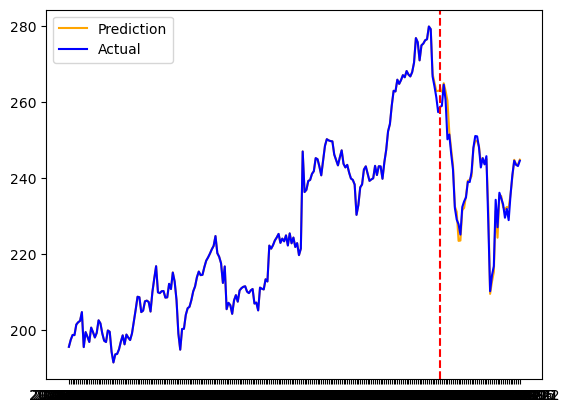

In [ ]:
plt.plot(df["date"], y_pred, color="orange")
plt.plot(df["date"], df[RESPONSE_VAR], color = "blue")
plt.legend(labels=["Prediction", "Actual"])
plt.axvline(TEST_START_INDEX, color="red", linestyle="--")

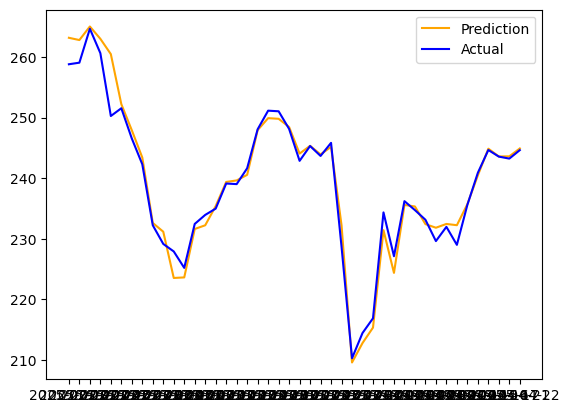

In [ ]:
plt.plot(df.loc[TEST_START_INDEX:, "date"], y_pred[TEST_START_INDEX:], color="orange")
plt.plot(df.loc[TEST_START_INDEX:, "date"], df.loc[TEST_START_INDEX:, RESPONSE_VAR], color = "blue")
plt.legend(labels=["Prediction", "Actual"])

## Testing strategy vs. Buy and Hold

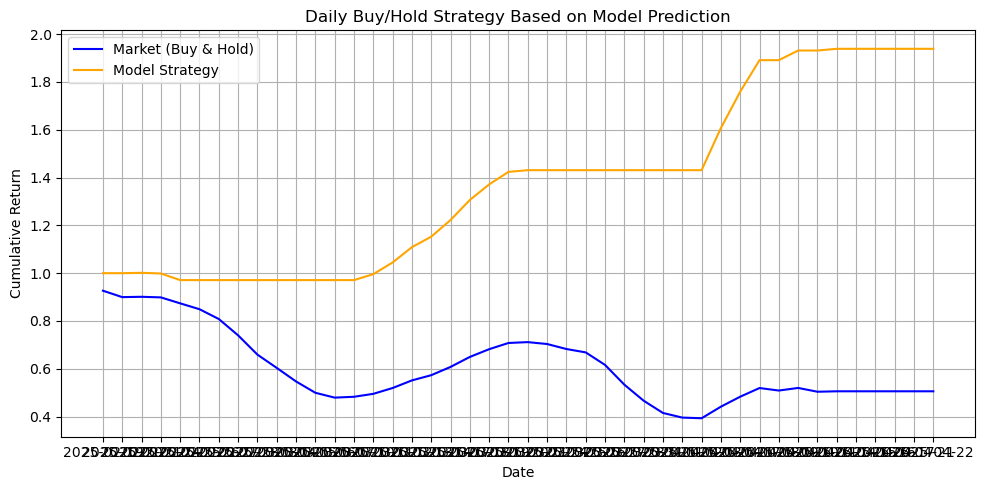

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assume y_pred is an array of predicted close prices
# Assume df contains 'date' and actual close price in RESPONSE_VAR
# Assume TEST_START_INDEX is the starting index of your OOT predictions

# 1. Extract test window
test_df = df.iloc[TEST_START_INDEX:].copy()
test_df["prediction"] = y_pred[TEST_START_INDEX:]

# 2. Calculate next-day return from actual closes
test_df["actual_close_t"] = test_df["close"]
test_df[f"actual_{RESPONSE_VAR}"] = test_df["actual_close_t"].shift(-5)
test_df["actual_return"] = (test_df[f"actual_{RESPONSE_VAR}"] - test_df["actual_close_t"]) / test_df["actual_close_t"]

# 3. Calculate model's expected return
test_df["predicted_return"] = (test_df["prediction"] - test_df["actual_close_t"]) / test_df["actual_close_t"]

# 4. Define buy signal: model predicts next-day return > 0
test_df["signal"] = (test_df["predicted_return"] > 0).astype(int)

# 5. Calculate strategy return: earn return only when signal == 1
test_df["strategy_return"] = test_df["actual_return"] * test_df["signal"]

# 6. Calculate cumulative returns
test_df["cumulative_market"] = (1 + test_df["actual_return"].fillna(0)).cumprod()
test_df["cumulative_strategy"] = (1 + test_df["strategy_return"].fillna(0)).cumprod()

# 7. Plot results
plt.figure(figsize=(10, 5))
plt.plot(test_df["date"], test_df["cumulative_market"], label="Market (Buy & Hold)", color='blue')
plt.plot(test_df["date"], test_df["cumulative_strategy"], label="Model Strategy", color='orange')
plt.legend()
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.title("Daily Buy/Hold Strategy Based on Model Prediction")
plt.grid(True)
plt.tight_layout()
plt.show()
